In [1]:
import os
import sys

assert "jax" not in sys.modules, "jax already imported: you must restart your runtime"
os.environ['XLA_FLAGS'] = "--xla_force_host_platform_device_count=4"

In [2]:
import jax
import jax.numpy as jnp
from jax.random import PRNGKey
from jax.typing import ArrayLike

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter


import datetime as dt
from epiweeks import Week

import arviz as az

import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

from pyrenew import observation, model, process, latent, deterministic, randomvariable
from pyrenew.process import RandomWalk
from pyrenew.latent import (
    Infections,
    InfectionInitializationProcess,
    InitializeInfectionsZeroPad,
    InitializeInfectionsExponentialGrowth,
    InfectionsWithFeedback
)
from pyrenew.deterministic import DeterministicPMF, DeterministicVariable
from pyrenew.metaclass import RandomVariable
from pyrenew.randomvariable import DistributionalVariable, TransformedVariable, StaticDistributionalVariable
import pyrenew.transformation as t

/Users/jingjieong/Projects/PyRenew/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Util functions

In [3]:
def conv(a: ArrayLike, b: ArrayLike) -> ArrayLike:
    """
    Helper function for convolution.
    """
    
    m = len(a)
    n = len(b)
    c = nc = np.zeros(m + n - 1)

    for i in range(m):       # Python index starts at idx
        for j in range(n):
            c[i + j] += a[i] * b[j]  # no -1 needed
    return c

def gamma_convert_param(mean, sd):
    shape = (mean**2)/(sd**2)
    scale = (sd**2)/mean

    return shape, scale


## plot utils
def format_quarterly_axis(ax):
    """
    Format a Matplotlib time axis to show quarterly ticks (Jan, Apr, Jul, Oct),
    with the year label shown only under January.
    """
    locator = mdates.MonthLocator(bymonth=[1, 4, 7, 10])
    ax.xaxis.set_major_locator(locator)

    def _custom_fmt(x, pos):
        date = mdates.num2date(x)
        if date.month == 1:
            return f"{date.strftime('%b')}\n{date.year}"
        else:
            return date.strftime('%b')

    ax.xaxis.set_major_formatter(FuncFormatter(_custom_fmt))
    return ax

### Data

In [4]:
covid_hosp_d = pd.read_excel("../sg_data/agg_covid_hosp_variant.xlsx", sheet_name="NEW_ACTIVE_HOSPITALISATION")
covid_variant_d = pd.read_excel("../sg_data/agg_covid_hosp_variant.xlsx", sheet_name="SARS-COV-2_VARIANT_PROPORTION")

covid_ari_d = pd.read_excel("../sg_data/agg_ari_ili.xlsx")

covid_hosp_d.rename(columns={"YEAR":"year","EPI-WEEK":"epi_week"}, inplace = True)
covid_variant_d.rename(columns={"YEAR":"year","EPI-WEEK":"epi_week"}, inplace = True)

def process_weeks_d(df):
    # Apply get_dates once and combine
    date_temp = df.apply(get_dates, axis=1)
    df = pd.concat([df, date_temp], axis=1)

    # Convert to datetime efficiently (vectorized)
    df[['start_date', 'end_date']] = df[['start_date', 'end_date']].apply(pd.to_datetime)

    # Create year-week column
    df['year_week'] = df['year'].astype(str) + "-" + df['epi_week'].astype(str)

    return df

# Apply the Week conversion to each row
def get_dates(row):
    try:
        epi_week = Week(int(row['year']), int(row['epi_week']))
        return pd.Series({
            'start_date': epi_week.startdate(),
            'end_date': epi_week.enddate()
        })
    except Exception as e:
        return pd.Series({
            'start_date': None,
            'end_date': None
        })

# Apply the function and combine results
covid_hosp_d = process_weeks_d(covid_hosp_d)
covid_ari_d = process_weeks_d(covid_ari_d)

covid_hosp_d.columns = covid_hosp_d.columns.str.lower()

covid_ari_d['ari_covid_positivity'] = covid_ari_d['ari_covid_pos'] / covid_ari_d['ari_samples']

#est covid case count
covid_ari_d['est_covid_cases'] = covid_ari_d['poly_ari_attendances'] * covid_ari_d['ari_covid_positivity']

# Merge hosp and ARI data
covid_ari_hosp_d = covid_ari_d.merge(covid_hosp_d[['year_week','new_hospitalisation_cases']],how='left',on = ['year_week'])

# Variant attributed case count
merged_df = pd.merge(covid_variant_d,covid_ari_d[['year','epi_week','est_covid_cases']], on = ['year','epi_week'],how = 'outer')
merged_df['est_variant_cases'] = merged_df['LINEAGE_PROPORTION'] * merged_df['est_covid_cases']

covid_variant_counts = merged_df.pivot_table(
    index = ['year','epi_week'],
    columns = 'LINEAGE_GROUP',
    values = 'est_variant_cases',
    fill_value = 0,
    aggfunc='sum'
).reset_index()

covid_variant_counts = process_weeks_d(covid_variant_counts)

### Set wave period
wave_period = {'start': ['2023-02-01','2023-10-01','2024-04-01','2025-03-01'],
               'end': ['2023-08-01','2024-03-01','2024-08-01','2025-10-01']}


### Visualise hospitalisation and estimated case counts with the variant proportions

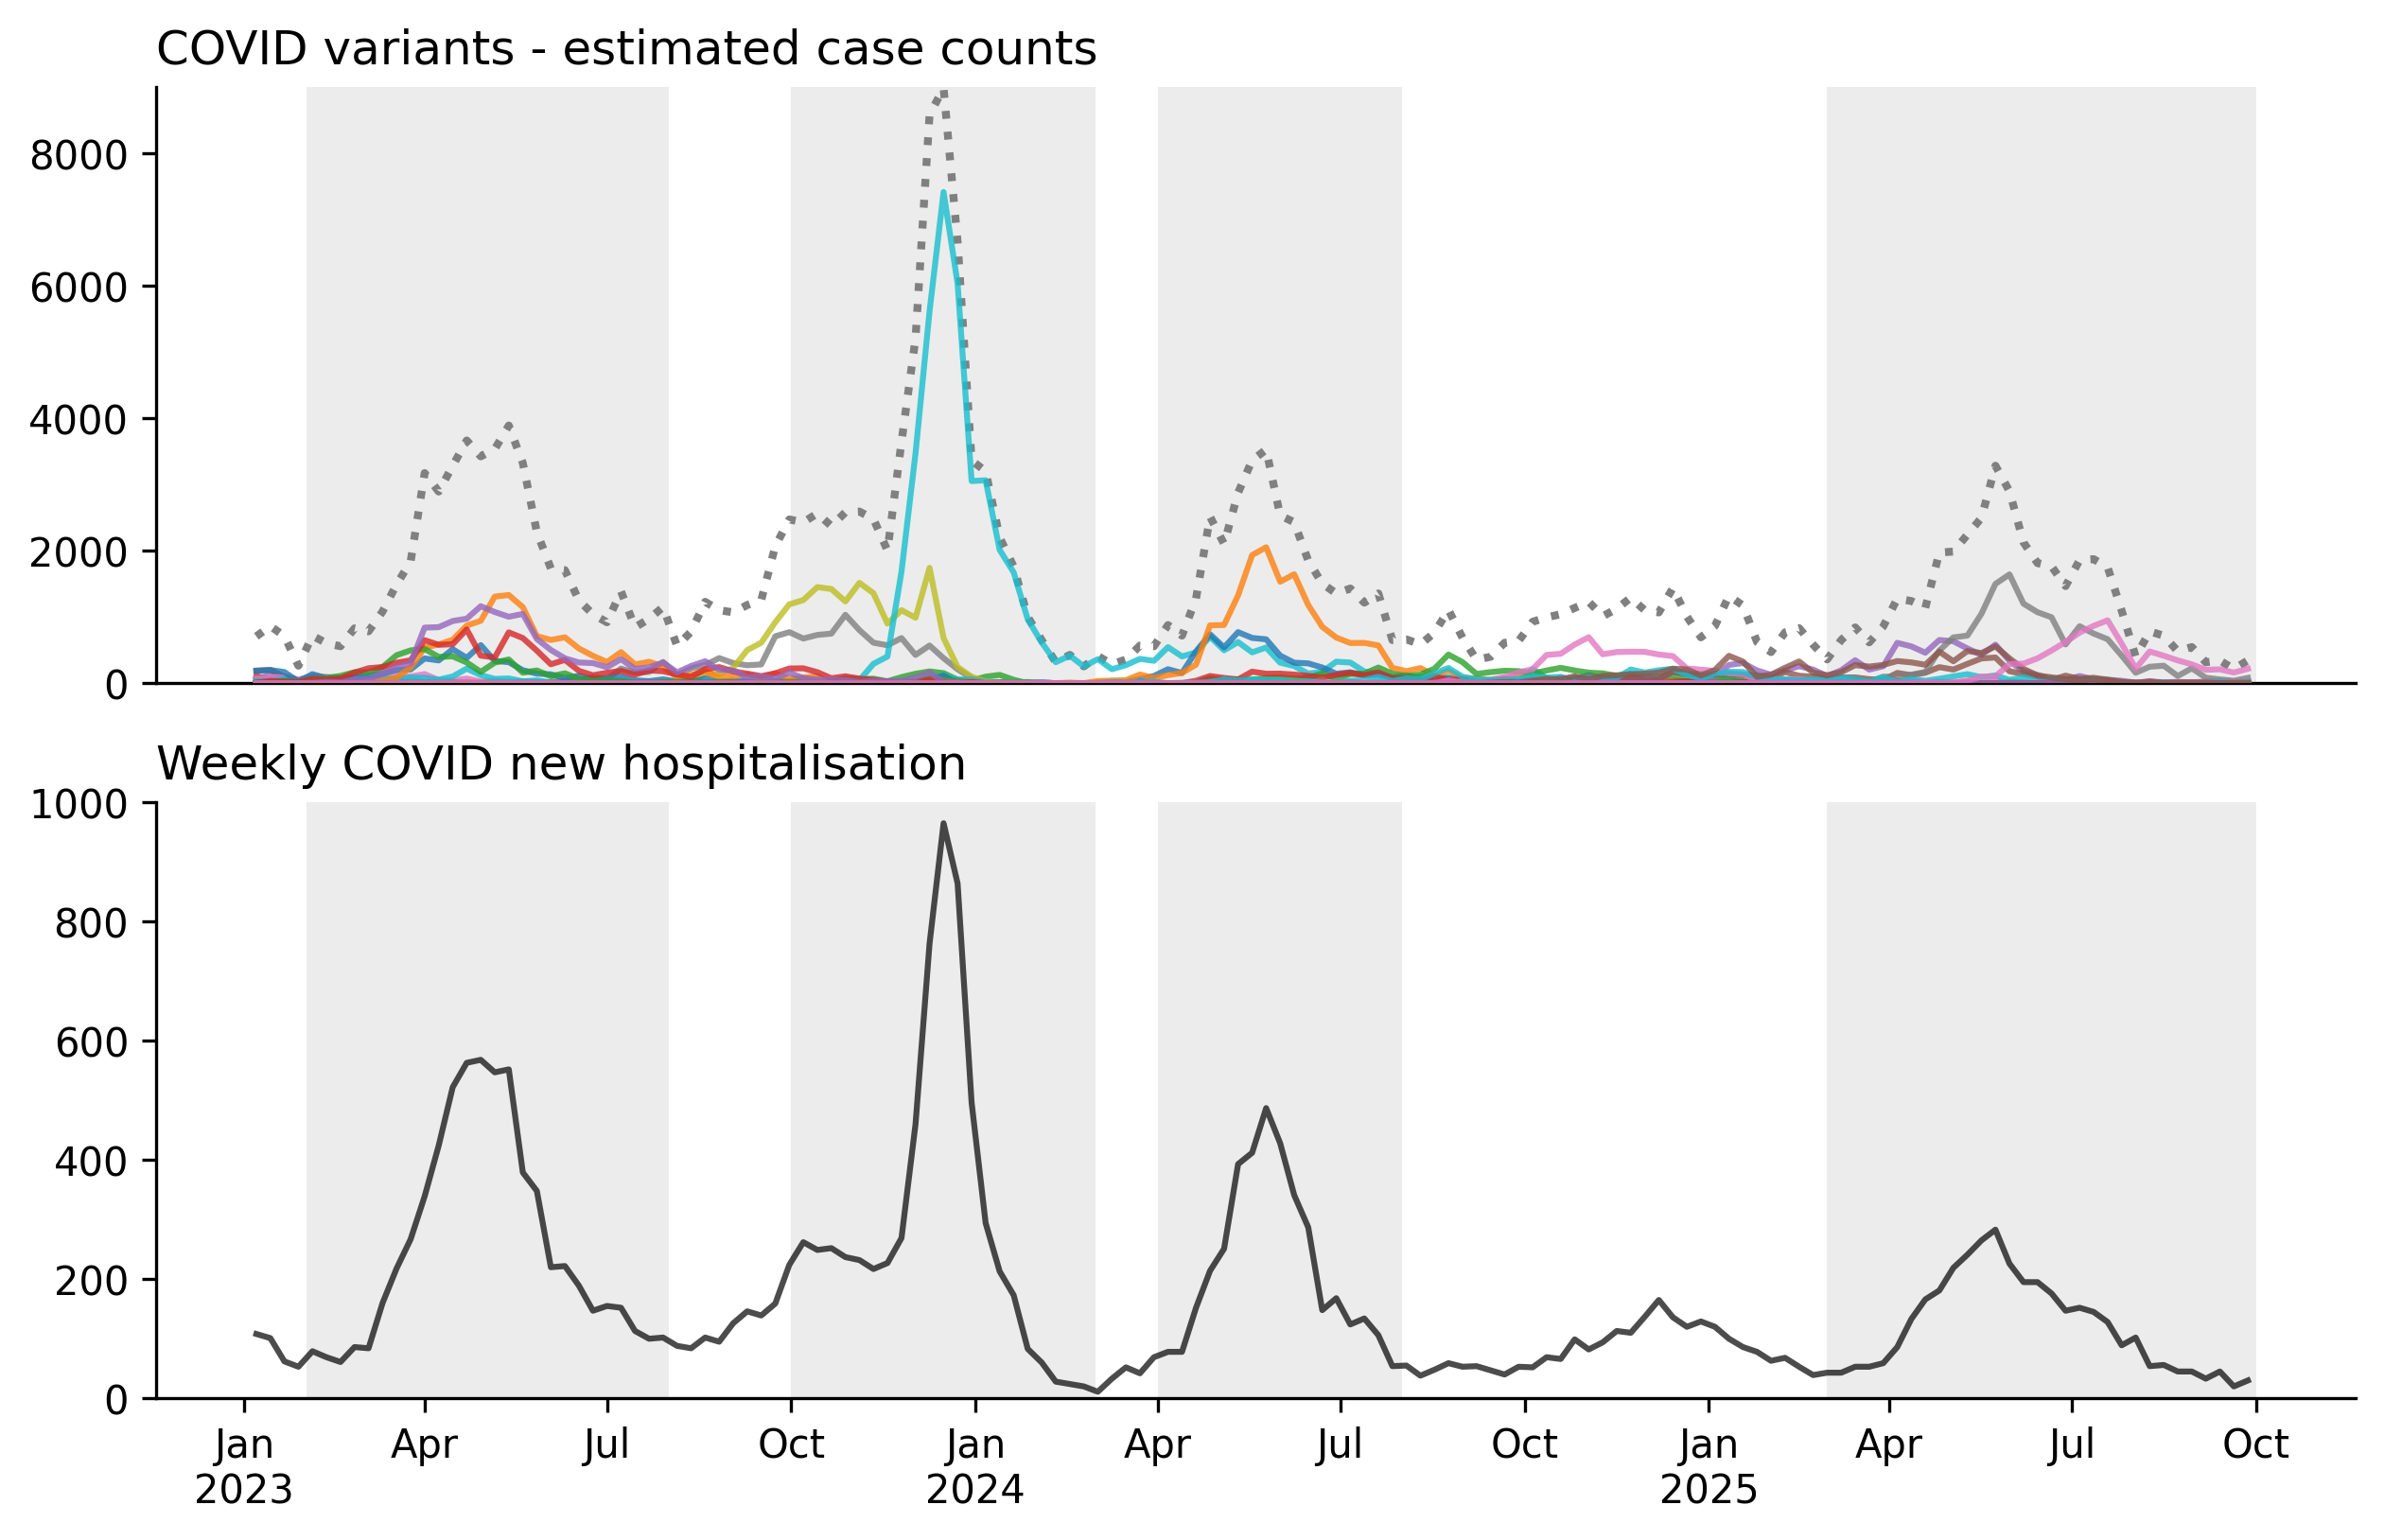

In [5]:
fig, ax = plt.subplots(2,1,figsize = (10,6),dpi=300)
plt.subplots_adjust(hspace = 0.2)

for v,x in zip(wave_period['start'], wave_period['end']):
    # ax[0].vlines(x = pd.to_datetime(v), ymin = 0, ymax = 10000, linestyles='dashed', alpha = 0.3, color = 'black',zorder=1)
    # ax[0].vlines(x = pd.to_datetime(x), ymin = 0, ymax = 10000, linestyles='dashed', alpha = 0.3, color = 'black',zorder=1)

    ax[0].axvspan(pd.to_datetime(v), pd.to_datetime(x), facecolor='grey', alpha=0.15,zorder=1)
    ax[1].axvspan(pd.to_datetime(v), pd.to_datetime(x), facecolor='grey', alpha=0.15,zorder=1)


ax[0].plot(covid_ari_d['end_date'],covid_ari_d['est_covid_cases'], color = 'grey', ls = 'dotted',lw = 2,zorder=2)

for variant in covid_variant_counts.drop(columns=['year','epi_week','start_date','end_date','year_week']).columns:
    ax[0].plot(covid_ari_d['end_date'],covid_variant_counts[variant], alpha = 0.8,zorder=3,label = variant)

ax[0].set_xticks([])

ax[1].plot(covid_ari_hosp_d['end_date'],covid_ari_hosp_d['new_hospitalisation_cases'], color = 'black', alpha = 0.7)


for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

format_quarterly_axis(ax[1])

ax[0].set_ylim(0,9000)
ax[1].set_ylim(0,1000)

ax[0].set_title("COVID variants - estimated case counts", loc = 'left')
ax[1].set_title("Weekly COVID new hospitalisation", loc = 'left')

plt.show()

### COVID Model 1: Jointly fit to hospitalisation and primary care cases
- setup delay distributions (generation time, infection to hospitalisation/primary care)
- setup ascertainment rate
- setup Rt (random walk), I0 seeding, infection process and latent process for hosp and primary care
- setup observation model

In [6]:
## Delays
onset_to_hosp = pd.read_csv('../sg_data/dist/dist_onset_hosp.csv') # SG COVID 2020 Data

## (2) COVID Generation time interval (mean and sd from Vattiatio et al DOI: 10.1016/j.epidem.2022.100657)
gen_time_mean = 3.3
gen_time_sd = 1.3
gen_time_shape, gen_time_scale = gamma_convert_param(gen_time_mean, gen_time_sd) 

x = jnp.arange(0, 101)
gamma_dist = dist.Gamma(concentration=gen_time_shape, rate=1/gen_time_scale)
gen_time_raw = jnp.exp(gamma_dist.log_prob(x))

gen_time_dist = gen_time_raw / gen_time_raw.sum() #normalise
gen_int_rv = DeterministicPMF(name="gen_int", value=gen_time_dist[:15])

## (3) infection to hospitalisation  - Convolute incubation with onset to hospitalisation
# source: Jantien et al (2022) DOI: 10.2807/1560-7917
x = jnp.arange(0, 11)  # 0:1:10
weibull_dist = dist.Weibull(concentration=1.5, scale=3.2)

incubation_raw = jnp.exp(weibull_dist.log_prob(x))
incub_norm = incubation_raw / incubation_raw.sum()

onset_to_hosp_dist = onset_to_hosp.onset_hosp / sum(onset_to_hosp.onset_hosp)
inf_hosp_dist = conv(incub_norm, onset_to_hosp_dist)

inf_hosp_int = DeterministicPMF(
    name="inf_hosp_int", value=inf_hosp_dist
)

## onset to primary care visits, https://www.thelancet.com/journals/lanwpc/article/PIIS2666-6065(23)00237-7/fulltext
x = jnp.arange(0,7)
ons_primary_dist = dist.Gamma(concentration = 1.2, rate = 1/0.9) #mean 1.3, sd = 1.2
ons_primary_raw = jnp.exp(ons_primary_dist.log_prob(x))
ons_primary_norm = ons_primary_raw / sum(ons_primary_raw)

# Infection to primary care visit convolution
inf_primary_dist = DeterministicPMF('inf_primary_dist', conv(incub_norm, ons_primary_norm))

# n_initialization_points = max(gen_int_rv.sample().size, inf_hosp_int_array.size, inf_shed_int_array.size) - 1
n_initialization_points = max(gen_int_rv.sample().size, inf_hosp_dist.size, inf_primary_dist().size) - 1

# Probability of symptomatic given COVID infections:
# https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30833-1/fulltext
# https://www.acpjournals.org/doi/10.7326/M20-3012?
p_sym = DistributionalVariable('p_sym',distribution = dist.Beta(40,60))

hosp_rate = DistributionalVariable(
    name='hosp_rate', distribution=dist.Uniform(1e-4, 0.5)
)

## Ascertainment rate for primary care visits
class Alpha_primary(RandomVariable):

    @staticmethod
    def validate():
        return None

    def sample(self, p_sym, n = None):

        # https://www.thelancet.com/journals/lanwpc/article/PIIS2666-6065%2823%2900237-7/fulltext?utm_source=chatgpt.com
        # ~75% seek primary care, later periods of COVID (2021-2022). Now COVID endemic, lesser testing and healthcare seeking.
        p_hseek_dist = DistributionalVariable('p_hseek', distribution = dist.Beta(60,40))
        p_hseek = p_hseek_dist.sample()

        p_visit_dist = DistributionalVariable('p_visit', distribution = dist.Beta(20,80))
        p_visit = p_visit_dist.sample()

        alpha_primary = numpyro.deterministic('alpha_primary',p_sym*p_hseek*p_visit)
        
        return alpha_primary

alpha_primary_rv = Alpha_primary()

# Latent severe cases (uses the hospitaladmission module)
latent_severeprimary = latent.SeverePrimary(
    infection_to_severe_interval_rv= inf_hosp_int,
    infection_to_primary_interval_rv=inf_primary_dist,
    infection_severe_ratio_rv= hosp_rate,
    infection_primary_ratio_rv=alpha_primary_rv,
    symptomatic_ratio_rv = p_sym
)


## (4) Set up Rt, I0, latent infection process and observation
I0 = InfectionInitializationProcess(
    "I0_initialization",
    randomvariable.DistributionalVariable(
        name="I0",
        distribution=dist.LogNormal(0,1),
    ),
    InitializeInfectionsExponentialGrowth(
        n_initialization_points,
        deterministic.DeterministicVariable(name="rate", value=0.05),
    ),
)

# The random walk on log Rt, with an inferred s.d. Here, we
# construct a custom RandomVariable.
class RtRandomWalk(RandomVariable):
    def validate(self):
        pass

    def sample(self, n: int, **kwargs) -> tuple:
        sd_rt = numpyro.sample("Rt_random_walk_sd", dist.HalfNormal(0.025))

        # Random walk step
        step_rv = randomvariable.DistributionalVariable(
            name="rw_step_rv", distribution=dist.Normal(0, sd_rt)
        )

        rt_init_rv = randomvariable.DistributionalVariable(
            name="init_log_rt", distribution=dist.Normal(0, 0.2)
        )

        # Random walk process
        base_rv = process.RandomWalk(
            name="log_rt",
            step_rv=step_rv,
        )

        # Transforming the random walk to the Rt scale
        rt_rv = randomvariable.TransformedVariable(
            name="Rt_rv",
            base_rv=base_rv,
            transforms=t.ExpTransform(),
        )
        init_rt = rt_init_rv.sample()

        return rt_rv.sample(n=n, init_vals=init_rt, **kwargs)

rtproc = RtRandomWalk()

# Latent infection process (which will use 1 and 2)
# feedback_strength = DeterministicVariable(name="feedback_strength", value=0.05)
# feedback_strength = DeterministicVariable(name="feedback_strength", value=0.01)

feedback_strength = DistributionalVariable(
    name = "feedback_strength", distribution = dist.LogNormal(-3,0.5)
)

latent_inf_feedback = InfectionsWithFeedback(
    infection_feedback_strength=feedback_strength,
    infection_feedback_pmf=gen_int_rv,
)

latent_inf = latent.Infections()

#Observation model - hospitalisation
nb_conc_hosp_rv = TransformedVariable(
    "concentration_hosp",
    randomvariable.DistributionalVariable(
        name="concentration_raw_hosp",
        distribution=dist.TruncatedNormal(loc=0, scale=1, low=0.01),
    ),
    t.PowerTransform(-2),
)

obs_h = observation.NegativeBinomialObservation(
    "negbinom_hosp_rv",
    concentration_rv=nb_conc_hosp_rv,    
)

#Observation model - primary care cases
nb_conc_primary_rv = TransformedVariable(
    "concentration_primary",
    randomvariable.DistributionalVariable(
        name="concentration_raw_primary",
        distribution=dist.TruncatedNormal(loc=0, scale=1, low=0.01),
    ),
    t.PowerTransform(-2),
)

obs_p = observation.NegativeBinomialObservation(
    "negbinom_primary_rv",
    concentration_rv=nb_conc_primary_rv,    
)

## If using wastewater, specify distribution and variables

# onset_to_shed = pd.read_csv('../sg_data/dist/dist_ww_shedding.csv') # Shedding distribution

# onset_to_shed_dist = onset_to_shed / sum(onset_to_shed.Shedding)
# inf_shed_int_array = conv(incubation, onset_to_shed_dist.Shedding.values)[3:]
# inf_shed_int_array = inf_shed_int_array / sum(inf_shed_int_array)

# inf_shed_int = deterministic.DeterministicPMF(
#     name="inf_shed_int", value=inf_shed_int_array
# )

# #Time-varying alpha RV
# class TimeVaryingAlpha(RandomVariable):
#     def validate(self):
#         pass

#     def sample(self, n: int, **kwargs):
#         alpha_rv = TransformedVariable(
#             name="log_alpha_random_walk",
#             base_rv=RandomWalk(
#                 name="log_alpha",
#                 step_rv=DistributionalVariable(
#                     name="alpha_rw_step_rv", distribution=dist.Normal(0, 0.2)
#                 ),
#             ),
#             transforms=t.ExpTransform(),
#         )
#         alpha_init_rv = DistributionalVariable(
#             name="init_log_alpha", distribution=dist.Normal(jnp.log(3e10), 2)
#         )
#         init_alpha = alpha_init_rv.sample()
#         return alpha_rv.sample(n=n + n_initialization_points, init_vals=init_alpha, **kwargs)

# # alpha = TimeVaryingAlpha()
# alpha = DeterministicVariable('alpha', 3e10)
# # alpha = DistributionalVariable(
# #     name='alpha_init', distribution=dist.Normal(jnp.log(3e10), 0.05)
# # )

# #Latent wastewater
# latent_wastewater = latent.Wastewater(
#     infection_to_shedding_rv=inf_shed_int,
#     alpha_rv = alpha
# )

# sigma_rv = TransformedVariable(
#     "log_sigma_ww",
#     DistributionalVariable(
#         "log_sigma_ww_raw",
#         dist.Normal(loc=0.0, scale=1.0),
#     ),
#     transforms=t.ExpTransform(),  # ensures positivity
# )

# obs_ww = observation.LogNormalObservation(
#     "lognorm_rv",
#     sigma_rv=sigma_rv
# )

### Fit for each wave period

In [ ]:
res_list = []
ari_hosp_d_comb = []

for idx in range(len(wave_period['start'])):

    ari_hosp_sub = covid_ari_hosp_d.loc[(covid_hosp_d['start_date'] >= wave_period['start'][idx]) & (covid_ari_hosp_d['end_date'] <= wave_period['end'][idx])]

    fit_model = model.SeverePrimaryModel(
        latent_infections_rv=latent_inf,
        latent_severe_primary_rv=latent_severeprimary,
        I0_rv=I0,
        gen_int_rv=gen_int_rv,
        Rt_process_rv=rtproc,
        severe_admission_obs_process_rv=obs_h,
        primary_care_cases_obs_process_rv=obs_p
    )

    # Run MCMC
    fit_model.run(
        num_samples=1000,
        num_warmup=1000,
        rng_key=jax.random.key(54),
        mcmc_args=dict(progress_bar=False, num_chains=2),
        data_observed_severe_admissions = ari_hosp_sub['new_hospitalisation_cases'].values,
        data_observed_primary_care_cases = ari_hosp_sub['est_covid_cases'].values,
        weekly_obs = True
        )
    
    ## Posterior predictive checks
    ppc_samples = fit_model.posterior_predictive(
        n_datapoints=len(ari_hosp_sub) * 7
    )

    idata = az.from_numpyro(
        posterior=fit_model.mcmc,
        posterior_predictive=ppc_samples
    )

    res_list.append(idata)
    ari_hosp_d_comb.append(ari_hosp_sub)


### Visualise model fit and estimated infection to hospitalisation rate for each wave

In [ ]:
fig, ax = plt.subplots(3,1,figsize = (10,6),dpi=300)
plt.subplots_adjust(hspace = 0.2)


ax[0].plot(covid_ari_hosp_d['end_date'],covid_ari_hosp_d['est_covid_cases'],'ko',alpha = 0.7, markersize=4, label = "observed")

ax[1].plot(covid_ari_hosp_d['end_date'],covid_ari_hosp_d['new_hospitalisation_cases'], 'ko',markersize = 4,alpha = 0.7)

for v,x in zip(wave_period['start'], wave_period['end']):
    ax[0].axvspan(pd.to_datetime(v), pd.to_datetime(x), facecolor='grey', alpha=0.15)
    ax[1].axvspan(pd.to_datetime(v), pd.to_datetime(x), facecolor='grey', alpha=0.15)

for res,d_sub in zip(res_list,ari_hosp_d_comb):
    pred_hosp = res.posterior_predictive.negbinom_hosp_rv.values.reshape(-1,len(d_sub),7).sum(axis=2)
    pred_pri = res.posterior_predictive.negbinom_primary_rv.values.reshape(-1,len(d_sub),7).sum(axis=2)    
    
    est_ihr = res.posterior_predictive.infection_severe_rate.values.reshape(-1)
    ihr_q = jnp.quantile(est_ihr,q = jnp.array([0.025,0.975]))

    hosp_q = jnp.quantile(pred_hosp,q = jnp.array([0.025,0.975]), axis = 0)
    pri_q = jnp.quantile(pred_pri,q = jnp.array([0.025,0.975]), axis = 0)

    ax[0].plot(d_sub['end_date'],jnp.mean(pred_pri,axis=0),color = 'mediumturquoise')
    ax[1].plot(d_sub['end_date'],jnp.mean(pred_hosp,axis=0),color = 'lightsteelblue')

    ax[0].fill_between(d_sub['end_date'],pri_q[0,],pri_q[1,],alpha = 0.3, color = 'mediumturquoise')
    ax[1].fill_between(d_sub['end_date'],hosp_q[0,],hosp_q[1,],alpha = 0.3, color = 'lightsteelblue')

    ax[2].plot(d_sub['end_date'], jnp.repeat(jnp.mean(est_ihr),len(d_sub['end_date'])), color = 'darksalmon')
    ax[2].fill_between(d_sub['end_date'],ihr_q[0,],ihr_q[1,],alpha = 0.3, color = 'darksalmon')

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

    a.set_xlim(pd.to_datetime('2023-01-01'))

# ax[2].tick_params('x',labelrotation = 90)
# ax[2].xaxis.set_major_locator(mdates.MonthLocator())
# ax[2].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

format_quarterly_axis(ax[2])

ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))

ax[0].set_ylim(0,12000)
ax[1].set_ylim(0,1000)
ax[2].set_ylim(0,0.03)
ax[0].set_xticks([])
ax[1].set_xticks([])

ax[0].set_title("COVID variants - estimated case counts", loc = 'left')
ax[1].set_title("Weekly COVID new hospitalisation", loc = 'left')
ax[2].set_title("Infection hospitalisation rate (Single rate for each period)", loc = 'left')

ax[0].legend()

plt.show()

### Single period fit for testing (define d_sub)

In [ ]:
##d_sub

fit_model = model.SeverePrimaryModel(
    latent_infections_rv=latent_inf,
    latent_severe_primary_rv=latent_severeprimary,
    I0_rv=I0,
    gen_int_rv=gen_int_rv,
    Rt_process_rv=rtproc,
    severe_admission_obs_process_rv=obs_h,
    primary_care_cases_obs_process_rv=obs_p
)

# Run MCMC
fit_model.run(
    num_samples=1000,
    num_warmup=1000,
    rng_key=jax.random.key(54),
    mcmc_args=dict(progress_bar=False, num_chains=2),
    data_observed_severe_admissions = hosp_sub['new_hospitalisation_cases'].values,
    data_observed_primary_care_cases = pri_sub['est_covid_cases'].values,
    weekly_obs = True
    )

## (7) Posterior predictive and MCMC diagnostics
idata = az.from_numpyro(fit_model.mcmc)

## Posterior predictive checks
ppc_samples = fit_model.posterior_predictive(
    n_datapoints=len(d_sub)
)

idata = az.from_numpyro(
    posterior=fit_model.mcmc,
    posterior_predictive=ppc_samples
)

In [ ]:
az.plot_trace(idata)

plt.tight_layout()
plt.show()

In [ ]:
diagnostic_stats_summary = az.summary(
    idata.posterior,
    var_names = 'Rt',
    filter_vars = 'regex',
    kind = 'all'
)
diagnostic_stats_summary

## Forecasts

In [ ]:
wave1_d = covid_ari_hosp_d.loc[(covid_ari_hosp_d['start_date'] >= wave_period['start'][0]) & 
                               (covid_ari_hosp_d['end_date'] <= wave_period['end'][0])]
## Set up model
fit_model = model.SeverePrimaryModel(
    latent_infections_rv=latent_inf,
    latent_severe_primary_rv=latent_severeprimary,
    I0_rv=I0,
    gen_int_rv=gen_int_rv,
    Rt_process_rv=rtproc,
    severe_admission_obs_process_rv=obs_h,
    primary_care_cases_obs_process_rv=obs_p
)

step = 14
t_fit = np.arange(14, len(wave1_d) * 7, step)
n_forecast = 14
t_forecast = t_fit + n_forecast

In [ ]:
def run_model(model,d_fit,t):
    model.run(
        num_samples=1000,
        num_warmup=1000,
        data_observed_severe_admissions=d_fit['new_hospitalisation_cases'].values,
        data_observed_primary_care_cases = d_fit['est_covid_cases'].values,
        rng_key=jax.random.key(54),
        mcmc_args=dict(progress_bar=False, num_chains=2),
        weekly_obs = True
    )

    ## Posterior predictive checks
    ppc_samples = model.posterior_predictive(
        n_datapoints=len(d_fit) * 7 + n_forecast
    )

    idata = az.from_numpyro(
        posterior=model.mcmc,
        posterior_predictive=ppc_samples
    )

    return idata

### Run forecasts for wave 1

In [ ]:
fore_res = []
d_fit_all = []

for idx in range(len(t_fit)):    
    
    d_fit = wave1_d.iloc[:t_fit[idx]//7]
    
    model_res = run_model(fit_model, d_fit = d_fit, t = t_forecast[idx])
    
    fore_res.append(model_res)
    d_fit_all.append(d_fit)

# idx = 5
# d_sub = wave1_d.iloc[:t_fit[idx]//7]
# d_fore = wave1_d.iloc[:t_forecast[idx]//7]

# idata, y_pri, y_hosp, y_rt = run_model(fit_model, d_fit = d_sub, t = t_forecast[idx])

In [ ]:
fig,ax=plt.subplots(3,4, figsize = (8,6),dpi=300)
ax = ax.ravel()
fig.subplots_adjust(hspace = 0.6, wspace = 0.1)

for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False) 
    a.set_ylim(0,1000)
    a.tick_params(axis='y', labelsize=6)
    a.tick_params(axis='x', labelsize=6, labelrotation = 90)

    a.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    a.xaxis.set_major_formatter(mdates.DateFormatter("%e-%b"))
    
for idx in range(len(fore_res)):
    window_d = wave1_d.iloc[max(0,(t_fit[idx] - 28)//7):t_forecast[idx]//7]
    ax[idx].plot(window_d['end_date'], window_d['new_hospitalisation_cases'], 'ko', markersize = 2)
    
    forec_date = d_fit_all[idx].iloc[-1]['end_date']
    ax[idx].vlines(forec_date, ymin = 0, ymax = ax[idx].get_ylim()[1], alpha = 0.5, linestyle = 'dotted', color = 'black')

    post_hosp = fore_res[idx].posterior_predictive.negbinom_hosp_rv.values.reshape(-1,t_forecast[idx]//7,7).sum(axis=2)
    post_hosp_q = jnp.quantile(post_hosp,q = jnp.array([0.025,0.975,0.25,0.75]), axis = 0)

    post_pri = fore_res[idx].posterior_predictive.negbinom_primary_rv.values.reshape(-1,t_forecast[idx]//7,7).sum(axis=2)
    post_pri_q = jnp.quantile(post_pri,q = jnp.array([0.025,0.975,0.25,0.75]), axis = 0)

    ax[idx].fill_between(window_d.iloc[-3:]['end_date'], post_hosp_q[0,-3:], post_hosp_q[1,-3:],alpha = 0.3, color = 'darkcyan')
    ax[idx].fill_between(window_d.iloc[-3:]['end_date'], post_hosp_q[2,-3:], post_hosp_q[3,-3:],alpha = 0.7, color = 'darkcyan')

    # ax[idx].fill_between(window_d.iloc[-3:]['end_date'], post_pri_q[0,-3:], post_pri_q[1,-3:],alpha = 0.3, color = 'orangered')
    # ax[idx].fill_between(window_d.iloc[-3:]['end_date'], post_pri_q[2,-3:], post_pri_q[3,-3:],alpha = 0.7, color = 'orangered')

    if idx % 4 != 0:
        ax[idx].set_yticks([])
    
    ax[idx].set_title(
    f"Week at: $\\bf{{{forec_date.strftime('%e-%b-%Y')}}}$",
    fontsize=6,
    loc='left'
    )
# plt.tight_layout()
plt.show()

In [ ]:

for idx in range(len(t_fit)):
    d_fit = d_2022.iloc[:t_fit[idx]]['nHosp'].values
    
    no_feedback_post = run_model(hosp_model_no_feedback, d_fit= d_fit, t = t_forecast[idx])
    feedback_post = run_model(hosp_model_feedback, d_fit= d_fit, t = t_forecast[idx])
    
    res_no_feedback_post.append(no_feedback_post)
    res_feedback_post.append(feedback_post)
   

In [ ]:
idx = 5
fig,ax = plt.subplots(dpi = 300)

entire_x = d_2022.date.iloc[t_fit[idx] - 14:t_forecast[idx]]
entire_y = d_2022.nHosp.iloc[t_fit[idx] - 14:t_forecast[idx]]
x_fore = d_2022.date.iloc[t_fit[idx]:t_forecast[idx]]
y_fore = d_2022.nHosp.iloc[t_fit[idx]:t_forecast[idx]]
# y_data = d_2022.nHosp.iloc[:t_fit[0]]

no_feedback_res_sub = res_no_feedback_post[idx][:,t_fit[idx]:t_forecast[idx]]
feedback_res_sub = res_feedback_post[idx][:,t_fit[idx]:t_forecast[idx]]

no_feedback_res_sub_quan = jnp.quantile(no_feedback_res_sub, q = np.array([0.025,0.975,0.25,0.75]),axis = 0)
feedback_res_sub_quan = jnp.quantile(feedback_res_sub, q = np.array([0.025,0.975,0.25,0.75]),axis = 0)


ax.plot(entire_x, entire_y, 'k')
ax.plot(x_fore, y_fore, color = 'red', label = "Actual data")

ax.vlines(d_2022.date.iloc[t_fit[idx]], ymin = 0, ymax = 400, color = 'black', linestyle = 'dotted')

ax.fill_between(x_fore, feedback_res_sub_quan[0,], feedback_res_sub_quan[1,], color = 'orange',alpha = 0.3, label = "90% credible interval")
ax.fill_between(x_fore, feedback_res_sub_quan[2,], feedback_res_sub_quan[3,], color = 'orange',alpha = 0.7, label = "50% credible interval")

ax.fill_between(x_fore, no_feedback_res_sub_quan[0,], no_feedback_res_sub_quan[1,], color = 'grey',alpha = 0.3, label = "90% credible interval")
ax.fill_between(x_fore, no_feedback_res_sub_quan[2,], no_feedback_res_sub_quan[3,], color = 'grey',alpha = 0.7, label = "50% credible interval")

ax.set_title("2-weeks ahead forecast for Omicron BA.1/2\n" + r"(2022 - Week $\bf{6}$)",loc='left')

ax.text(d_2022.date.iloc[t_fit[idx]-5], 380, s = 'Reported')
ax.text(d_2022.date.iloc[t_fit[idx]+1], 380, s = 'Forecast')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False) 
ax.set_ylabel("New COVID Hospitalisation")
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylim(0, 400)

ax.legend(bbox_to_anchor = (1.5,0.7))

plt.show()

### Evaluate forecasts (MAE,Coverage, WIS)

In [ ]:
mae = 0

for idx in range(len(res_post)):
    ypred = res_post[idx][:,t_fit[idx]:].mean(axis=0)
    yobs = d_wave1.nHosp[t_fit[idx]:t_forecast[idx]]

    mae += np.sum(ypred - yobs)

mae / len(yobs)

In [ ]:
covered_95 = 0
q95 = np.array([0.025,0.975])
 
for idx in range(len(res_post)):
    y_int = jnp.quantile(res_post[idx][:,t_fit[idx]:], q = q95, axis = 0)
    lower = y_int[0,:]
    upper = y_int[1,:]
    yobs = d_wave1.nHosp[t_fit[idx]:t_forecast[idx]]

    covered_95 += np.sum((yobs >= lower) & (yobs <= upper))


coverage_q95 = covered_95 / len(d_wave1.iloc[t_fit[0]:])

covered_50 = 0
q50 = np.array([0.25,0.75])
 
for idx in range(len(res_post)):
    y_int = jnp.quantile(res_post[idx][:,t_fit[idx]:], q = q50, axis = 0)
    lower = y_int[0,:]
    upper = y_int[1,:]
    yobs = d_wave1.nHosp[t_fit[idx]:t_forecast[idx]]

    covered_50 += np.sum((yobs >= lower) & (yobs <= upper))


coverage_q50 = covered_50 / len(d_wave1.iloc[t_fit[0]:])

In [ ]:
def compute_wis(y, median, intervals):
    """
    y        : observed value (scalar)
    median   : predictive median
    intervals: list of tuples [(alpha, lower, upper), ...]
               where alpha is e.g. 0.1 for 90% PI
    """
    K = len(intervals)
    score = 0.5 * abs(y - median)

    for alpha, lower, upper in intervals:
        width = upper - lower
        penalty = 0
        if y < lower:
            penalty = (2 / alpha) * (lower - y)
        elif y > upper:
            penalty = (2 / alpha) * (y - upper)

    score += (alpha / 2) * (width + penalty)

    return score / (K + 0.5)

wis = 0

for idx in range(len(res_post)):
    y_int95 = jnp.quantile(res_post[idx][:,t_fit[idx]:],
                            q = np.array([(1-0.95)/2,0.5,0.95 + (1-0.95)/2]),
                            axis = 0)
    
    y_int80 = jnp.quantile(res_post[idx][:,t_fit[idx]:],
                        q = np.array([(1-0.8)/2,0.8 + (1-0.8)/2]),
                        axis = 0)

    y_int50 = jnp.quantile(res_post[idx][:,t_fit[idx]:],
                        q = np.array([(1-0.5)/2,0.5 + (1-0.95)/2]),
                        axis = 0)
    
    yobs = d_wave1.nHosp[t_fit[idx]:t_forecast[idx]].values
    med = y_int95[1,:]

    for n in np.arange(0,len(yobs)):
        wis += compute_wis(y = yobs[n], median = med[n], intervals = [(0.5,y_int50[0,:][n],y_int50[1,:][n]),
                                                                      (0.8,y_int80[0,:][n],y_int80[1,:][n]),
                                                                      (0.95,y_int95[0,:][n],y_int95[2,:][n])])


mean_wis = wis / len(yobs)

In [ ]:
wis,mean_wis